In [1]:
import librosa.feature
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
from pesq import pesq

from src.paths import DATA_DIR
from src.pipeline import run_testing_pipeline

SAMPLE_RATE = 16000
AUDIO_FILE = DATA_DIR / "LJ025-0076.wav"
TEXT = "Many animals of even complex structure which live parasitically within others are wholly devoid of an alimentary cavity."

### End-to-end waveform reconstruction PESQ test 

In [2]:
for with_reconstruction in [True, False]:
    print(f"Running tests with waveform reconstruction: {with_reconstruction}")
    run_testing_pipeline(
        directory=DATA_DIR,
        reconstruct=with_reconstruction,
        n_fft=512,
        win_length=512,
        hop_length=256,
        n_mels=128,
        window="hann",
        power=2.0,
    )

Running tests with waveform reconstruction: True


0it [00:00, ?it/s]

MEAN PESQ: 4.049919536113739
STD PESQ: 0.11523315229600567
MAX PESQ: 4.341282367706299
MIN PESQ: 3.7181694507598877
Running tests with waveform reconstruction: False


0it [00:00, ?it/s]

MEAN PESQ: 4.643888473510742
STD PESQ: 0.0
MAX PESQ: 4.643888473510742
MIN PESQ: 4.643888473510742


### Step-by-step waveform reconstruction with visuals

Sample rate: 16000 Hz
Duration: 8.297 seconds
Number of samples: 132747
Text: Many animals of even complex structure which live parasitically within others are wholly devoid of an alimentary cavity.


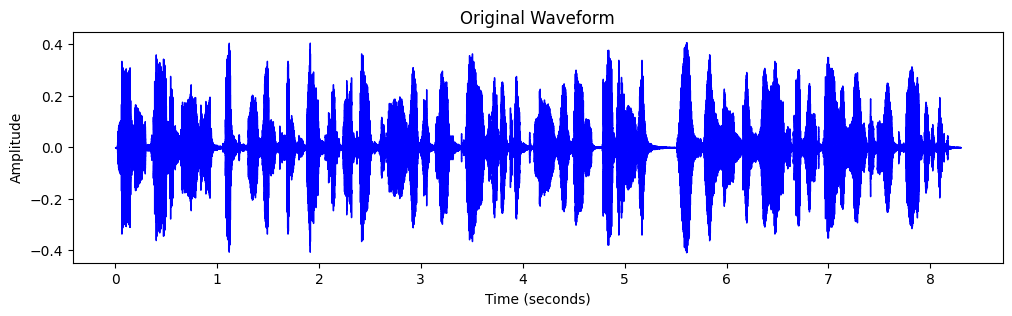

In [3]:
original_waveform, sample_rate = librosa.load(AUDIO_FILE, sr=SAMPLE_RATE)
duration = librosa.get_duration(y=original_waveform, sr=sample_rate)
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {duration:.3f} seconds")
print(f"Number of samples: {len(original_waveform)}")
print(f"Text: {TEXT}")

plt.figure(figsize=(12, 3))
librosa.display.waveshow(original_waveform, sr=sample_rate, color="blue")
plt.title("Original Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(data=original_waveform, rate=sample_rate)

Mel spectrogram shape: (128, 519)


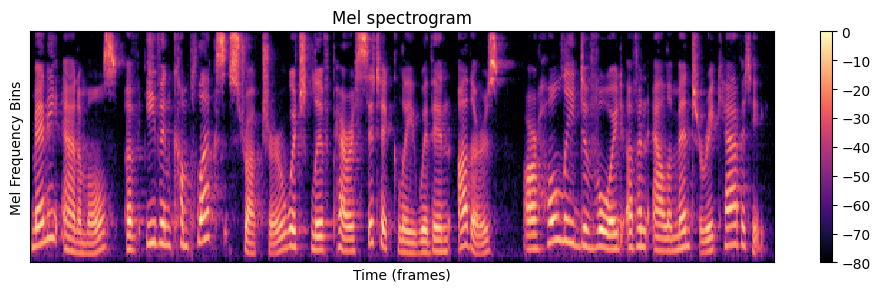

In [4]:
mel_spectrogram = librosa.feature.melspectrogram(
    y=original_waveform,
    sr=sample_rate,
    n_fft=512,
    win_length=512,
    hop_length=256,
    n_mels=128,
    window="hann",
    power=2.0,
)
print(f"Mel spectrogram shape: {mel_spectrogram.shape}")

plt.figure(figsize=(12, 3))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max))
plt.title("Mel spectrogram")
plt.xlabel("Time (frames)")
plt.ylabel("Mel Frequency Bins")
plt.colorbar()
plt.show()

STFT magnitude shape: (257, 519)


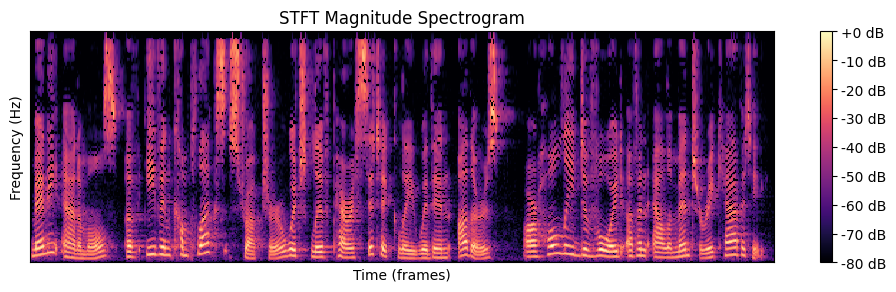

In [5]:
stft_magnitude = librosa.feature.inverse.mel_to_stft(
    mel_spectrogram,
    sr=sample_rate,
    n_fft=512,
    power=2.0
)
print(f"STFT magnitude shape: {stft_magnitude.shape}")

plt.figure(figsize=(12, 3))
librosa.display.specshow(librosa.amplitude_to_db(stft_magnitude, ref=np.max))
plt.title("STFT Magnitude Spectrogram")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.0f dB")
plt.show()

Duration: 8.288 seconds
Number of samples: 132608


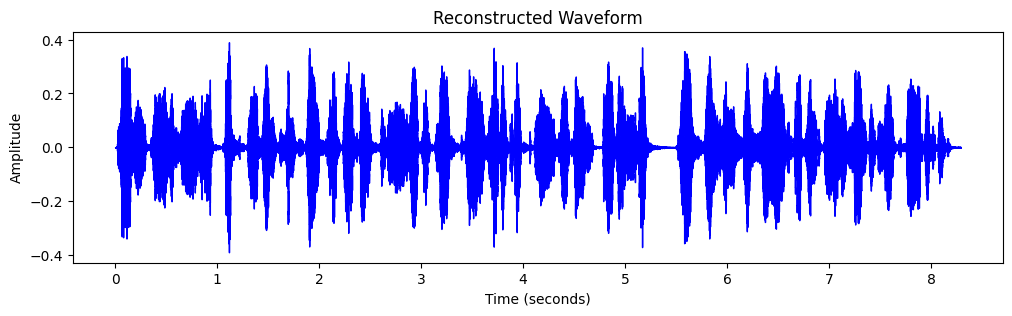

In [6]:
reconstructed_waveform = librosa.griffinlim(
    stft_magnitude,
    n_fft=512,
    win_length=512,
    hop_length=256,
    window="hann",
)

duration = librosa.get_duration(y=reconstructed_waveform, sr=sample_rate)
print(f"Duration: {duration:.3f} seconds")
print(f"Number of samples: {len(reconstructed_waveform)}")

plt.figure(figsize=(12, 3))
librosa.display.waveshow(reconstructed_waveform, sr=sample_rate, color="blue")
plt.title("Reconstructed Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(data=reconstructed_waveform, rate=sample_rate)

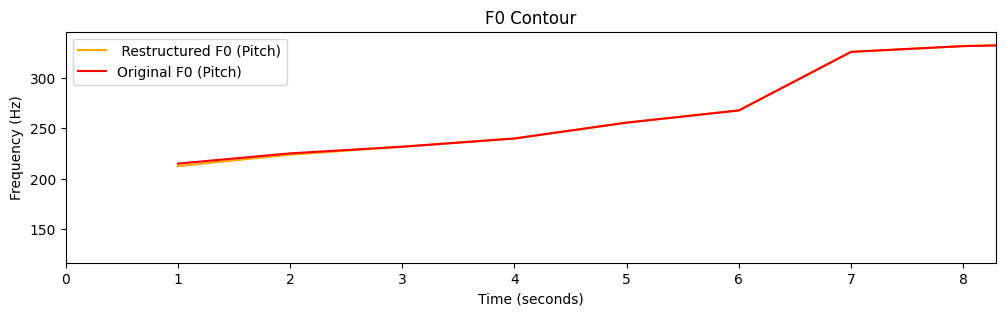

In [7]:
restructured_f0, *_ = librosa.pyin(
    reconstructed_waveform,
    fmin=librosa.note_to_hz("C2").item(),
    fmax=librosa.note_to_hz("C7").item(),
    sr=sample_rate,
    frame_length=2048,
    hop_length=512,
)

original_f0, *_ = librosa.pyin(
    original_waveform,
    fmin=librosa.note_to_hz("C2").item(),
    fmax=librosa.note_to_hz("C7").item(),
    sr=sample_rate,
    frame_length=2048,
    hop_length=512,
)

plt.figure(figsize=(12, 3))
plt.plot(restructured_f0, color="orange", label=" Restructured F0 (Pitch)")
plt.plot(original_f0, color="red", label="Original F0 (Pitch)")
plt.title("F0 Contour")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.xlim(0, duration)
plt.legend()
plt.show()

In [8]:
min_length = min(len(original_waveform), len(reconstructed_waveform))

pesq_score = pesq(
    fs=SAMPLE_RATE,
    ref=original_waveform[:min_length],
    deg=reconstructed_waveform[:min_length],
    mode="wb",
)
print(f"PESQ Score: {pesq_score:.3f}")

PESQ Score: 4.122
